## Model Selection

In [68]:
from warnings import filterwarnings
from time import perf_counter

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer

from helpers import constants as C

In [69]:
filterwarnings("ignore")

In [70]:
df = pd.read_csv("data/processed/mumbai/res_apartment_dataset.csv")
print(df.shape)
df.head()

(8024, 19)


,PROP_ID,CITY,PRICE,AREA,PROPERTY_TYPE,FURNISH,FACING,AGE,BEDROOM_NUM,BALCONY_NUM,FLOOR_NUM,LOCALITY_NAME,LUXURY_CATEGORY,PROP_HEADING,DESCRIPTION,PROP_NAME,LATITUDE,LONGITUDE,SOCIETY_NAME
0,https://99acres.com/HTTPS://99ACRES.COM/A70699844,thane,23000000.0,1040.0,residential apartment,semifurnished,north-west,1-5 year old property,2.0,1.0,high rise,balkum,1,2 bhk flat in balkum,piramal vaikunth is one of thane's most sought...,piramal vaikunth,19.223389,72.989916,piramal vaikunth
1,https://99acres.com/HTTPS://99ACRES.COM/H69523096,central mumbai suburbs,9099000.0,481.0,residential apartment,semifurnished,east,under construction,2.0,99.0,low rise,bhandup west,2,2 bhk flat in bhandup west,enjoy a blissful living experience in marathon...,marathon neovalley,19.148382,72.932412,marathon neovalley
2,https://99acres.com/HTTPS://99ACRES.COM/X70319554,mumbai south west,27700000.0,749.0,residential apartment,semifurnished,east,under construction,2.0,99.0,low rise,santacruz east,2,2 bhk flat in santacruz east,"book your 2 bhk flat in santacruz east, mumbai...",kolte alora,19.081032,72.857794,kolte alora
3,https://99acres.com/HTTPS://99ACRES.COM/P68170490,south mumbai,48600000.0,1215.0,residential apartment,semifurnished,east,under construction,3.0,99.0,low rise,lower parel,2,3 bhk flat in lower parel,"there is a 3 bhk apartment in lower parel, sou...",arihant towers by mj shah,18.999908,72.846725,arihant towers by mj shah
4,https://99acres.com/HTTPS://99ACRES.COM/S70951224,navi mumbai,3600000.0,339.0,residential apartment,semifurnished,east,under construction,1.0,99.0,low rise,shilphata,2,1 bhk flat in shilphata,"mansarovar residency is a residential project,...",mansarovar residency,19.144990,73.037922,mansarovar residency


In [71]:
df.isnull().sum()

PROP_ID            0
CITY               0
PRICE              0
AREA               0
PROPERTY_TYPE      0
FURNISH            0
FACING             0
AGE                0
BEDROOM_NUM        0
BALCONY_NUM        0
FLOOR_NUM          0
LOCALITY_NAME      0
LUXURY_CATEGORY    0
PROP_HEADING       0
DESCRIPTION        0
PROP_NAME          0
LATITUDE           0
LONGITUDE          0
SOCIETY_NAME       0
dtype: int64

In [72]:
target = "PRICE"
num_cols = [
    "AREA",
]
cat_cols = [
    "FURNISH",
    "AGE",
    "BEDROOM_NUM",
    "BALCONY_NUM",
    "FLOOR_NUM",
    "FACING",
    "LOCALITY_NAME",
]

In [73]:
main_df = df[[target] + num_cols + cat_cols].copy(True)
print(main_df.shape)
main_df.head()

(8024, 9)


,PRICE,AREA,FURNISH,AGE,BEDROOM_NUM,BALCONY_NUM,FLOOR_NUM,FACING,LOCALITY_NAME
0,23000000.0,1040.0,semifurnished,1-5 year old property,2.0,1.0,high rise,north-west,balkum
1,9099000.0,481.0,semifurnished,under construction,2.0,99.0,low rise,east,bhandup west
2,27700000.0,749.0,semifurnished,under construction,2.0,99.0,low rise,east,santacruz east
3,48600000.0,1215.0,semifurnished,under construction,3.0,99.0,low rise,east,lower parel
4,3600000.0,339.0,semifurnished,under construction,1.0,99.0,low rise,east,shilphata


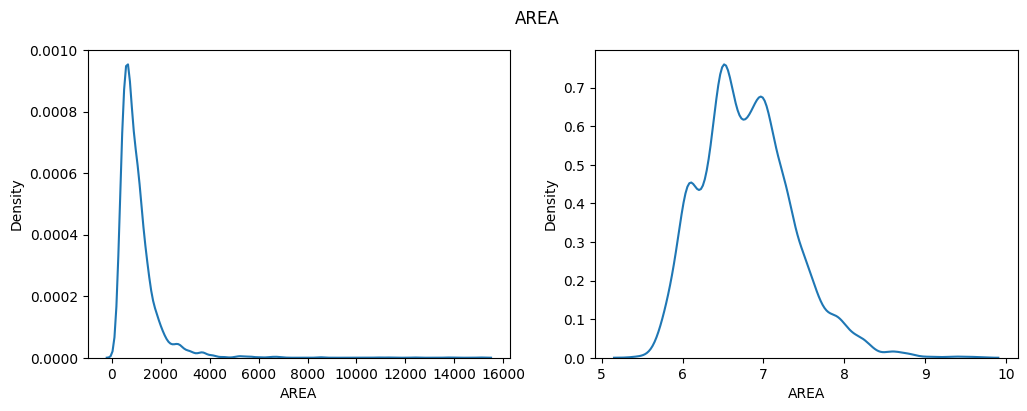

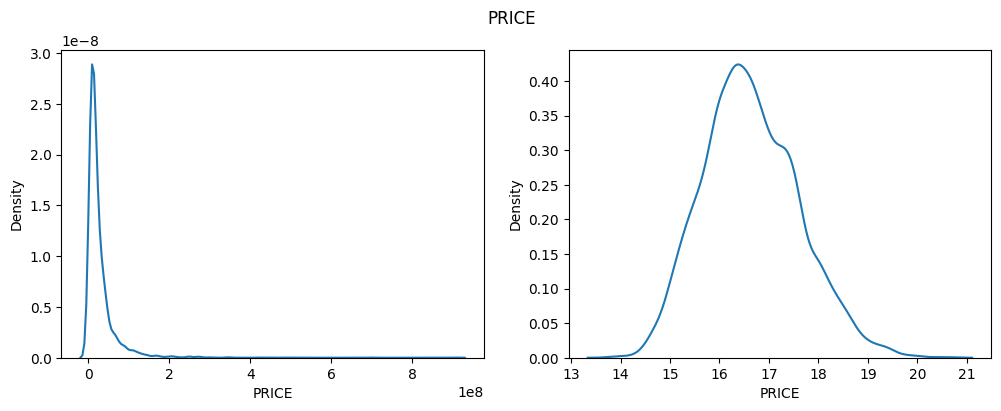

In [74]:
for i in ["AREA", "PRICE"]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(x=main_df[i], ax=ax1)
    sns.kdeplot(x=np.log1p(main_df[i]), ax=ax2)

    fig.suptitle(i)
    plt.show()

<Axes: >

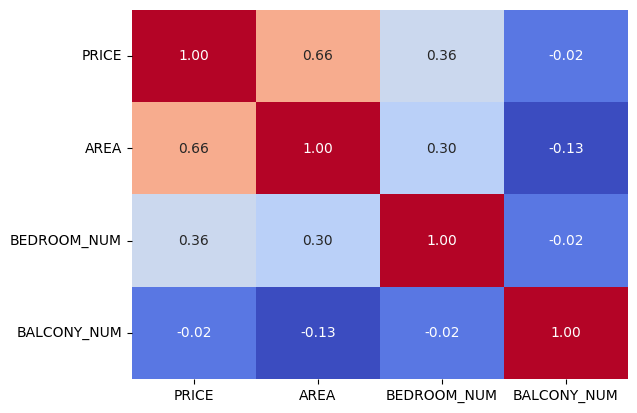

In [75]:
sns.heatmap(main_df.corr(numeric_only=True), cmap="coolwarm", cbar=False, annot=True, fmt=".2f")

### Encoding of categorical features

In [76]:
main_df["BEDROOM_NUM"] = main_df["BEDROOM_NUM"].apply(lambda x: x if x <= 5 else 99)
main_df["BALCONY_NUM"] = main_df["BALCONY_NUM"].apply(lambda x: x if x <= 4 else 99)

In [77]:
for col in cat_cols:
    if main_df[col].nunique() < 20:
        print(f"{col!r:>18}: {main_df[col].unique().tolist()}")
    else:
        print(f"{col!r:>18}: {main_df[col].nunique()}")

         'FURNISH': ['semifurnished', 'furnished', 'unfurnished']
             'AGE': ['1-5 year old property', 'under construction', '0-1 year old property', '5-10 year old property', '10+ year old property']
     'BEDROOM_NUM': [2.0, 3.0, 1.0, 5.0, 4.0, 99.0]
     'BALCONY_NUM': [1.0, 99.0, 2.0, 3.0, 0.0, 4.0]
       'FLOOR_NUM': ['high rise', 'low rise', 'mid rise']
          'FACING': ['north-west', 'east', 'north', 'west', 'south', 'south-east', 'north-east', 'south-west']
   'LOCALITY_NAME': 502


In [78]:
ord_cols = {
    'FURNISH': ['unfurnished', 'semifurnished', 'furnished'],  # Ensure correct order
    "AGE": ['under construction', '0-1 year old property', '1-5 year old property', 
            '5-10 year old property', '10+ year old property'],  # Sorted logically
    "BEDROOM_NUM": sorted([2.0, 3.0, 1.0, 5.0, 4.0, 99.0]),  # Ensure sorting
    "BALCONY_NUM": sorted([1.0, 99.0, 2.0, 3.0, 0.0, 4.0]),   # Ensure sorting
    "FLOOR_NUM": ['low rise', 'mid rise', 'high rise'],  # Logical order
}
ohe_cols = ["FACING", "LOCALITY_NAME"]

### Encoding Pipeline

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=list(ord_cols.values())), list(ord_cols.keys())),
        ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ohe_cols),
        ("log1p_area", FunctionTransformer(np.log1p, np.expm1, validate=True), ["AREA"]),
    ],
    remainder="passthrough",
)

### Split Dataset

In [80]:
X = main_df.drop(columns=[target])
y = pd.Series(np.log1p(main_df[target]), name="PRICE")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
X_train.shape, X_test.shape

((6419, 8), (1605, 8))

In [82]:
def calc_scores(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)

    mae = mean_absolute_error(y_true, y_pred) / C.LAKH
    return mae

In [83]:
def create_model_pipe(estimator, preprocessor: ColumnTransformer | None):
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("scaler", StandardScaler()),
            ("model", estimator),
        ]
    )

In [84]:
models_dict = {
    # This throw error that while transforming the y_pred data some data goes to infinity.
    # Also, it has very low r2_score approx (-7.778398599756416e+22)
    # "lr": LinearRegression(),
    #"ridge_default": Ridge(),
    #"rf_100": RandomForestRegressor(n_estimators=100),
    "rf_500": RandomForestRegressor(n_estimators=500),
    "svr_rbf": SVR(kernel="rbf"),
}

In [86]:
def calc_cv_score(X_train, y_train, *, X_test=None, y_test=None) -> dict:
    scores_dict = {}

    if X_test is None or y_test is None:
        X_test = X_train
        y_test = y_train

    for name, estimator in models_dict.items():
        start_time = perf_counter()
        scores = cross_val_score(
            model := create_model_pipe(estimator, preprocessor),
            X_train,
            y_train,
            cv=5,
            scoring="r2",
        )

        print(f"Fitting `{name}` model with {scores.mean():.3} R2 score.")
        model.fit(X_train, y_train)
        
         # Save the trained model using joblib
        model_filename = f"{name}_model.pkl"
        import pickle

        model_path = "model/rf_500_res_apartment_model.pkl"

        with open(model_path, "wb") as file:
            pickle.dump(trained_model, file)  # trained_model should be your RandomForestRegressor

        print(f"Saved `{name}` model to {model_filename}")
        
        scores_dict[name] = {
            "r2_mean": scores.mean(),
            "r2_std": scores.std(),
            "mae": calc_scores(y_test, model.predict(X_test)),
        }
        print(f"{name} model takes {(perf_counter() - start_time):.3} seconds.\n")

    return scores_dict

In [87]:
def dict_to_df(d: dict) -> pd.DataFrame:
    return pd.DataFrame.from_dict(d, "index").sort_values("mae").round(3)

In [88]:
# Training model with testing datasets
scores_dict = calc_cv_score(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
dict_to_df(scores_dict)

Fitting `rf_500` model with 0.911 R2 score.


NameError: name 'trained_model' is not defined

In [61]:
scores_dict = calc_cv_score(X, y)
dict_to_df(scores_dict)

Fitting `ridge_default` model with 0.923 R2 score.
ridge_default model takes 1.78 seconds.

Fitting `rf_100` model with 0.97 R2 score.
rf_100 model takes 58.5 seconds.

Fitting `rf_500` model with 0.971 R2 score.
rf_500 model takes 2.88e+02 seconds.

Fitting `svr_rbf` model with 0.893 R2 score.
svr_rbf model takes 77.4 seconds.



,r2_mean,r2_std,mae
rf_500,0.971,0.002,14.430
rf_100,0.970,0.002,15.019
ridge_default,0.923,0.004,51.419
svr_rbf,0.893,0.006,56.315


## we got Random Forest with `estimator as 500` as `BEST Model` 
## so training the rf500 each property type